In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, RMSprop

In [12]:
import os
from sklearn.model_selection import train_test_split

# Define the path to your dataset
dataset_path = "./dataset"

# Initialize lists to store data
labels = []
images = []

# Iterate over image files in the dataset folder
for img_path in os.listdir(dataset_path):
    # Read and preprocess the image
    image = cv2.imread(os.path.join(dataset_path, img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (48, 48))  # Adjust the size according to your model's input size

    # Extract the label from the filename
    label = img_path.split('_')[0]

    # Append data to lists
    labels.append(label)
    images.append(image)

# Convert lists to numpy arrays
labels = np.array(labels)
images = np.array(images)


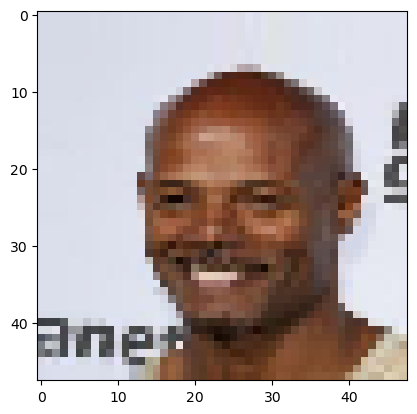

In [13]:
plt.imshow(images[87])

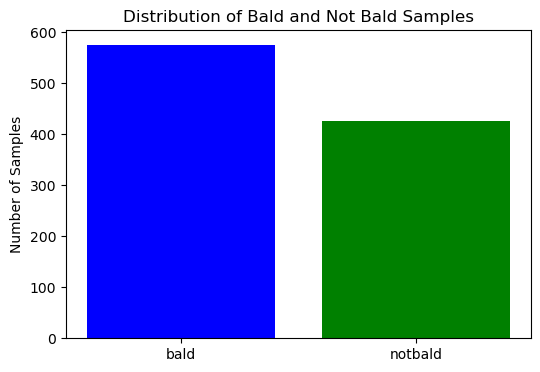

In [15]:
# Count the occurrences of 'Bald' and 'Not Bald'
bald_count = np.sum(labels == 'bald')
not_bald_count = np.sum(labels == 'notbald')

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))

# Bar plot for 'Bald' and 'Not Bald'
categories = ['bald', 'notbald']
counts = [bald_count, not_bald_count]

ax.bar(categories, counts, color=['blue', 'green'])
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Bald and Not Bald Samples')

plt.show()

In [20]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [21]:
label_mapping = {'bald': 0, 'notbald': 1}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])


In [22]:
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Activation, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming you have X_train, y_train, X_val, y_val defined
label_mapping = {'bald': 0, 'notbald': 1}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])

def Convolution(input_tensor, filters):
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding="same", strides=(1, 1), kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x = Activation('relu')(x)
    return x

def create_bald_detection_model(input_shape):
    inputs = Input(shape=input_shape)
    conv_1 = Convolution(inputs, 32)
    maxp_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    conv_2 = Convolution(maxp_1, 64)
    maxp_2 = MaxPool2D(pool_size=(2, 2))(conv_2)
    conv_3 = Convolution(maxp_2, 128)
    maxp_3 = MaxPool2D(pool_size=(2, 2))(conv_3)
    conv_4 = Convolution(maxp_3, 256)
    maxp_4 = MaxPool2D(pool_size=(2, 2))(conv_4)
    flatten = Flatten()(maxp_4)
    dense_1 = Dense(64, activation='relu')(flatten)
    drop_1 = Dropout(0.2)(dense_1)

    output = Dense(1, activation='sigmoid', name='baldness_out')(drop_1)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
    return model



In [18]:
bald_model = create_bald_detection_model((48, 48, 3))
bald_model.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                           

In [23]:
file_save = 'model.h5'
checkpoint = ModelCheckpoint(file_save, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = EarlyStopping(patience=75, monitor='val_loss', restore_best_weights=True)
callback_list = [checkpoint, early_stop]



In [24]:
history_bald = bald_model.fit(X_train, y_train_numeric, batch_size=64, validation_data=(X_val, y_val_numeric), epochs=25, callbacks=callback_list)

Epoch 1/25
13/13 [==============================] - ETA: 0s - loss: 15.0556 - accuracy: 0.5025
Epoch 1: val_loss improved from inf to 1.07315, saving model to Bald_Detection.h5
13/13 [==============================] - 4s 177ms/step - loss: 15.0556 - accuracy: 0.5025 - val_loss: 1.0732 - val_accuracy: 0.4450
Epoch 2/25
13/13 [==============================] - ETA: 0s - loss: 1.0307 - accuracy: 0.5525
Epoch 2: val_loss improved from 1.07315 to 0.97272, saving model to Bald_Detection.h5
13/13 [==============================] - 2s 153ms/step - loss: 1.0307 - accuracy: 0.5525 - val_loss: 0.9727 - val_accuracy: 0.7050
Epoch 3/25
13/13 [==============================] - ETA: 0s - loss: 0.9349 - accuracy: 0.6700
Epoch 3: val_loss improved from 0.97272 to 0.92820, saving model to Bald_Detection.h5
13/13 [==============================] - 2s 163ms/step - loss: 0.9349 - accuracy: 0.6700 - val_loss: 0.9282 - val_accuracy: 0.7200
Epoch 4/25
13/13 [==============================] - ETA: 0s - loss: 0

7/7 [==============================] - 0s 18ms/step


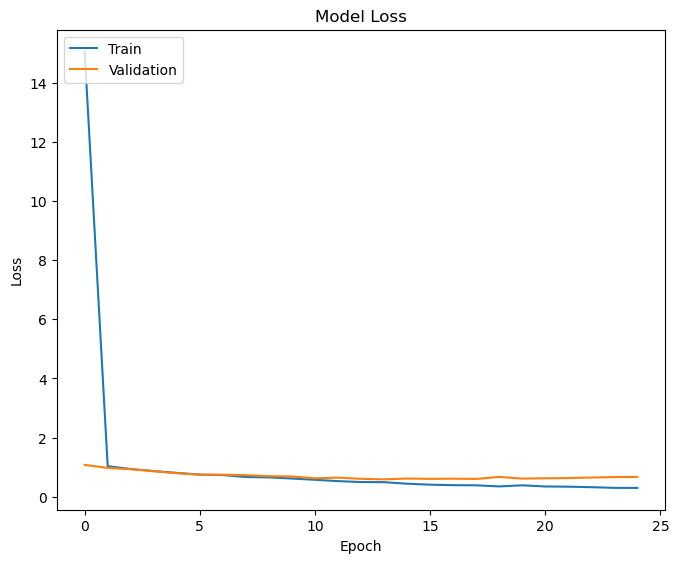

In [29]:
# Assuming you have X_test, Y_test, history_bald, and bald_model defined
bald_model.evaluate(X_val,y_val_numeric )  

pred_bald = bald_model.predict(X_val)

# Model loss plot
plt.plot(history_bald.history['loss'])
plt.plot(history_bald.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0, hspace=0.25, wspace=0.35)

